# Introduction to Ensembling/Stacking in Python
---
https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook   
캐글 필사 스터디를 진행하면서 기존에 작성된 코드 및 설명을 필사한다.   

## Introduction
이 노트북은 모델들을 앙상블하는 방법에 대한 아주 기본적이고 간단한 입문서이며, 특히 Stacking으로 알려진 다양한 앙상블 기법이다. 간략히 애기하면 Stacking은 **몇 가지 기본적인 분류기의 예측값을 사용한(first-level) 다음 first-level로부터 예측한 값으로 output을 예측하기 위해 다른 모델를 사용한다(second-level).**

Titanic dataset은 캐글을 시작하는 많은 임문자들에게 Stacking의 개념을 도입하기 위한 중요한 후보이다. 게다가 Stacking이 캐글 대회에서 많은 팀들의 우승의 원인이였지만, 이 주제에 대한 커널들이 부족해 보인다. 그래서 이 노트북이 부족한 것들을 채워 주길 바란다.

나 자신도 Kaggle scene에서 꽤 신입이고, 우연히 발견하고 연구하여 처음으로 적절하게 작성한 Ensembling/Stacking script는 Faron이 AllState Severity Claims competition 작성된 것이다. **이 노트북 자료는 Faron의 script를 많이 차용했지만, Faron의 regressor of ensemble를 classifier of ensemble로 변환하였다.** 어쨋든 Faron의 script는 여기서 확인해라.  
- [Stacking Starter](https://www.kaggle.com/code/mmueller/stacking-starter) : by Faron

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

일반화된 대부분의 커널 방법처럼 진행한다. 첫번째로 데이터를 탐구하고, 가능한 특징 엔지니어링 기회를 식별하고 어떤 범주형 특징들을 수치적으로 인코딩한다.

In [44]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 임무는 어떻게든 범주형 변수에서 정보를 추출하는 일이다.

### Feature Engineering

여기서, 특징 엔지니어링 아이디어를 포괄적이고 잘 고안해 놓은 Sina의 노트북을 확인하라.
- [Titanic Best Working Classfier](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier) : by Sina

In [45]:
full_data = [train, test]

# <-- Feature Engineering -->
# some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone From Family Size
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles fo passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# <-- Data Cleaning -->
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare' ] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare' ] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare' ] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare' ] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age' ] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age' ] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age' ] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age' ] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age' ] = 4

In [46]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

feature engineering, cleaning, drop categorical columns를 수행하면 모든 feature들은 숫자여야 하며 Machine Learning models에 먹이기에 적합한 포맷이어야 한다. 하지만 우리는 진행하기 이전에 변환된 데이터셋의 간단한 상관관계와 분포를 확인하겠다.
## Visualisations

In [47]:
train.head(3)
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


### Pearson Correlation Heatmap
하나의 특성이 다른 특성들과 얼마나 관련있느지 확인하기 위해 특징들의 상관관계를 그린다. 그렇게 하기위해, 우리는 heatmap을 펼리하게 그릴 수 있는 Seaborn plotting 패키지를 활용 할 것이다.

<AxesSubplot:title={'center':'Person Correlation of Features'}>

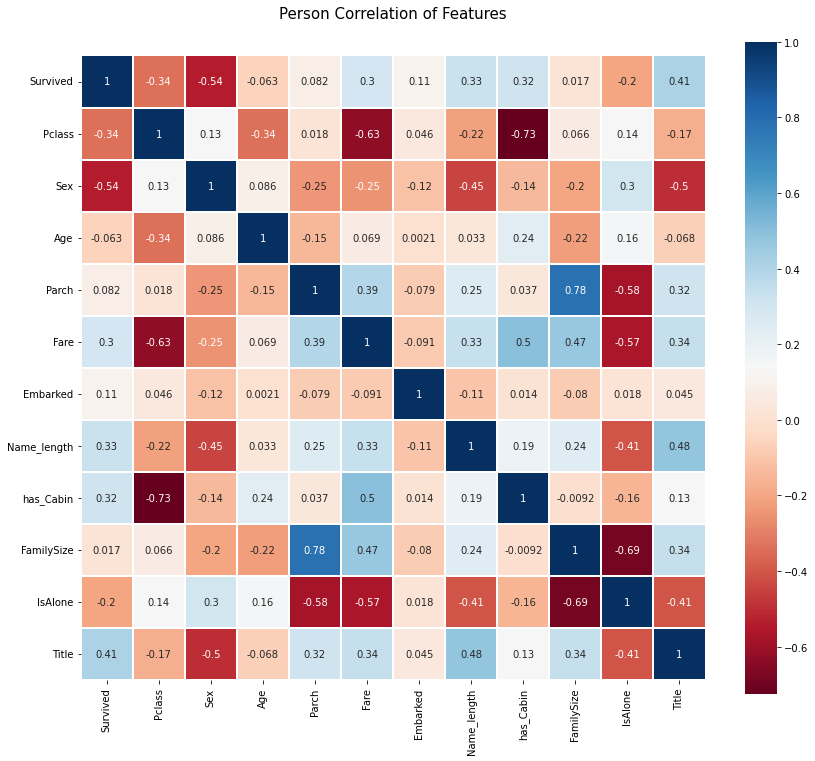

In [48]:
colormap = plt.cm.RdBu # colormap config
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the Plots
Pearson Correlation plot를 보면 알 수 있는 사실은 서로 강하게 상관되는 많은 feature가 없다는 것이다. 이것은 train 데이터에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하고 각 특징에 고유한 정보가 포함되어 있다는 것이기 때문에 학습 모델에 특징을 제공하는 관점에서 좋다. 여기서 가장 상관관계가 큰 두 개의 특징은 Family size와 Parch 이다. 훈련의 목적을 위해 두 개의 특징을 그대로 둘 것이다.

### Pairplots
하나의 특징이 다른 것들에 데이터 분포를 관측하기 위해 pairplot를 사용한다.

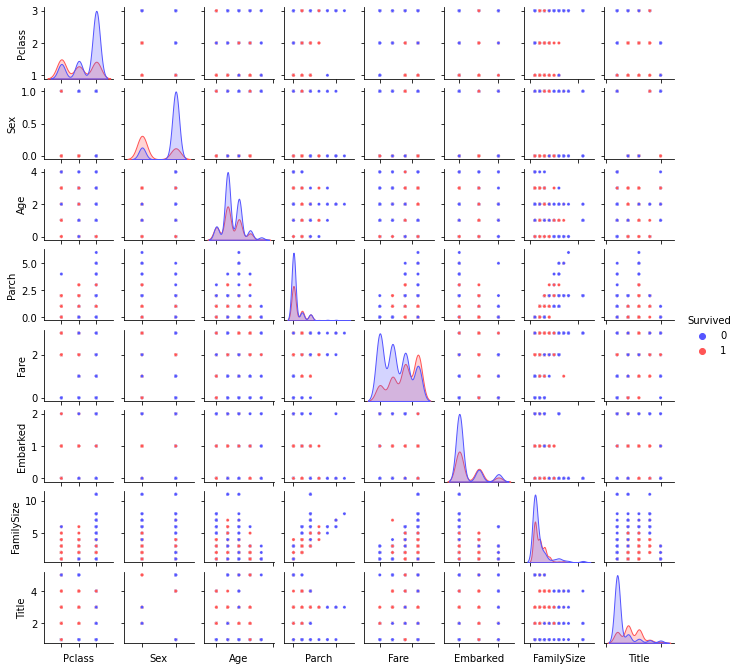

In [49]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, 
                diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models
feature engineering과 formatting을한 후, 우리는 이 노트북의 핵심에 도달했다.
Stacking ensemble 만들기!

### Helpers via Python Classes
우리는 파이썬 클래스를 호출하여 더 편리하게 만든다.

아래 코드에서, 우리는 기본적으로 모든 SKlearn Classifier에 공통적으로 내장되어있는 함수들을 사용하기위한 SklearnHelper class를 작성한다. 그러므로 5개의 다른 classifier를 호출하기 원한다면 같은 메소드를 반복적으로 사용하지 않아도 된다.

In [65]:
# Some useful parameters which will com in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)
        
# Class to extend XGboost classifer

### Out-of-Fold Predictions
앞서 말한 것 처럼 Stacking은 기본 분류기의 예측을 second-level model 학습을 위해 입력으로 사용한다. 하지만, 모든 training data를 기본 모델에 학습하여 모든 test set의 예측값을 생성하고 이후 second-level 학습을 위해 output을 사용할 수 없다. 이것은 기본 모델들이 이미 test set을 본 상태가 되며 그러므로 예측에 오버피팅이 발생한다.

In [66]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        print(i, train_index, test_index)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
first level 분류로써 5개의 모델을 준비한다. 이 모델들은 SKlearn library를 통해 편리하게 사용할 수 있다.
1. Random forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

#### Parameters
파라미터들 설명  
**n_jobs** : 학습을 위해 사용되는 코어 수. 만약 설정이 -1면 모든 코어가 사용된다.  
**n_estimators** : 학습 모델 트리 분류기 개수(기본 10개)  
**max_depth** : 최대 트리 깊이 or 얼마나 노드를 확장할지. 너무 깊게하면 overfitting 될 수 있다.  
**verbose** : 학습 과정을 텍스트로 표현할지 안할지 조정. 0을 주면 보이지 않고, 3을주면 모든 반복 동작에 대해 보여줌  

In [67]:
# Put in our parameters for said classifiers
# Random Forest Parameters
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    #'max_features' : 0.2,
    'max_depth' : 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [68]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
# gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
# svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

#### Creating Numpy arrays out of our train and test sets
first level의 기존 모델들이 준비 됬다. 우리는 dataframe으로부터 Numpy arrays를 생성함으로써 분류기에 input으로 넣기 위한 train set과 test set을 준비할 수 있다.

In [54]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Create an array of the test data

array([[3, 1, 2, ..., 1, 1, 1],
       [3, 0, 2, ..., 2, 0, 3],
       [2, 1, 3, ..., 1, 1, 1],
       ...,
       [3, 1, 2, ..., 1, 1, 1],
       [3, 1, 1, ..., 1, 1, 1],
       [3, 1, 2, ..., 3, 0, 4]], dtype=int64)

#### Output of the First level Predictions

In [69]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest

0 [179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412
 413 414 415 416 417 418 419 420 421 422 423 424 

3 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 